In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from keras.regularizers import l1_l2
from keras.regularizers import l2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

tf.config.run_functions_eagerly(True)

In [ ]:
# This is only needed if you are wanting to save the model to google drive. You can either save it locally or just not save it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
!nvidia-smi

Sat May  6 02:20:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |    373MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import and preprocess the data sets

In [ ]:
# API to download data set from kaggle, we then unzip it in the next cell, will unzip it to the local content of the google drive instance
# this means each time you close and open this notebook, you will need to redownload and extract the dataset
os.environ['KAGGLE_USERNAME'] = "ezmgszi"
os.environ['KAGGLE_KEY'] = "1e61368ff35db29b1a61a8fa576dc124"
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

100% 750M/750M [00:36<00:00, 22.6MB/s]
100% 750M/750M [00:36<00:00, 21.6MB/s]


In [ ]:
!unzip /content/stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

In [ ]:
# custom preprocessing function for use by our ImageDataGenerator
def custom_preprocessing(image):
    # Convert the image to a numpy array and rescale it to [0, 1]
    image_np = np.array(image) / 255.0

    # Apply histogram equalization
    if len(image_np.shape) == 3:
        # Convert the image to YUV color space
        yuv_image = cv2.cvtColor(np.float32(image_np), cv2.COLOR_RGB2YUV)

        # Equalize the Y channel
        yuv_image[:,:,0] = cv2.equalizeHist(np.uint8(yuv_image[:,:,0] * 255)) / 255

        # Convert the image back to RGB color space
        equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)
    else:
        equalized_image = cv2.equalizeHist(np.uint8(image_np * 255)) / 255

    # Subtract the mean pixel value (optional)
    mean_pixel = np.mean(equalized_image)
    centered_image = equalized_image - mean_pixel

    # Normalize the image (optional)
    min_value, max_value = centered_image.min(), centered_image.max()
    normalized_image = (centered_image - min_value) / (max_value - min_value)

    return normalized_image

In [ ]:
# Data importing, splitting and augmentation
image_size = (224, 224)
batch_size = 32
path_raw_datasets = '/content/images/Images'

#set up keras image data generator for data sugmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    )

# split into train set
train_generator = train_datagen.flow_from_directory(
    path_raw_datasets,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

#split to valadation set
validation_generator = train_datagen.flow_from_directory(
    path_raw_datasets,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [ ]:
# This section is just to show the images, augementation and preprocessing for the report
breeds = os.listdir(path_raw_datasets)
num_samples = 3

sample_images = []

for _ in range(num_samples):
    breed = random.choice(breeds)
    breed_dir = os.path.join(path_raw_datasets, breed)
    image_name = random.choice(os.listdir(breed_dir))
    image_path = os.path.join(breed_dir, image_name)
    sample_images.append(image_path)

preprocessed_images = []
custom_preprocessed_images = []
for img_path in sample_images:
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    preprocessed_img_array = train_datagen.random_transform(img_array[0])
    preprocessed_images.append(preprocessed_img_array)
    custom_preprocessed_img_array = custom_preprocessing(preprocessed_img_array)
    custom_preprocessed_images.append(custom_preprocessed_img_array)

sample_breeds = []
for img_path in sample_images:
    breed = img_path.split(os.path.sep)[-2]
    sample_breeds.append(breed)


fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

for i in range(num_samples):
    # Load and display the original image
    original_img = image.load_img(sample_images[i], target_size=image_size)
    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title('Original Image\nBreed: {}'.format(sample_breeds[i]))
    axes[i, 0].axis('off')
    
    # Display the preprocessed image
    preprocessed_img = image.array_to_img(preprocessed_images[i])
    axes[i, 1].imshow(preprocessed_img)
    axes[i, 1].set_title('Transform Image\nBreed: {}'.format(sample_breeds[i]))
    axes[i, 1].axis('off')

    # Display the custom preprocessed image
    custom_preprocessed_img = image.array_to_img(custom_preprocessed_images[i])
    axes[i, 2].imshow(custom_preprocessed_img)
    axes[i, 2].set_title('Preprocessed Image\nBreed: {}'.format(sample_breeds[i]))
    axes[i, 2].axis('off')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

Custom model

In [ ]:
# create our custom model custom architecture

model = Sequential([
    #block 1
    Conv2D(64, (3, 3), activation='relu', input_shape=(*image_size, 3), padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    #block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),


    #block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(120, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] )

In [ ]:
model.build((244, 244, 3))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 120)               61560     
                                                                 
Total params: 24,675,448
Trainable params: 1,110,648
Non-trainable params: 23,564,800
_________________________________

In [ ]:
# set up our training  perameters, checkpounts, early stopping and scheduling
model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

In [ ]:
# train the custom model, 50 epochs, badic adam defaults to starting LR of 0.001, schedule learning rate will change over time
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=validation_generator, 
                    callbacks=[checkpoint,earlystopping, reduce_lr]
                    )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


516/516 [==============================] - ETA: 0s - loss: 5.4487 - accuracy: 0.0152
Epoch 1: val_loss improved from inf to 4.75229, saving model to model.h5
516/516 [==============================] - 555s 1s/step - loss: 5.4487 - accuracy: 0.0152 - val_loss: 4.7523 - val_accuracy: 0.0211 - lr: 0.0010
Epoch 2/50
516/516 [==============================] - ETA: 0s - loss: 4.9547 - accuracy: 0.0256
Epoch 2: val_loss did not improve from 4.75229
516/516 [==============================] - 474s 919ms/step - loss: 4.9547 - accuracy: 0.0256 - val_loss: 4.7657 - val_accuracy: 0.0263 - lr: 0.0010
Epoch 3/50
516/516 [==============================] - ETA: 0s - loss: 4.7144 - accuracy: 0.0320
Epoch 3: val_loss did not improve from 4.75229
516/516 [==============================] - 474s 917ms/step - loss: 4.7144 - accuracy: 0.0320 - val_loss: 4.9879 - val_accuracy: 0.0187 - lr: 0.0010
Epoch 4/50
516/516 [==============================] - ETA: 0s - loss: 4.5197 - accuracy: 0.0425
Epoch 4: val_loss i

In [ ]:
# save our model, add whatever path you want here
model_save_path = '/content/drive/MyDrive/Predicting Pooches/Custom CNN.pt'
model.save(model_save_path)

Model Evaluations

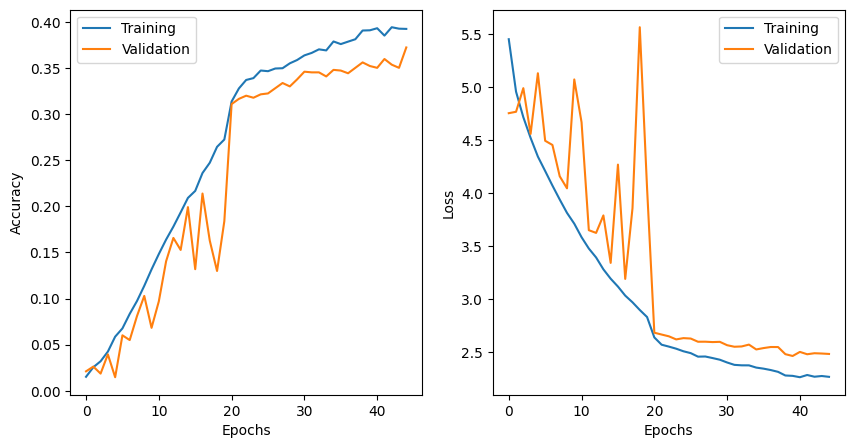

In [ ]:
#plot our loss and accuracy metrics
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Pretraind model

In [ ]:
# Pretrained model 

# Load the pre-trained ResNet50V2 model without the top (classification) layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Set the base model layers as non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model with the pre-trained ResNet50V2 base model and custom top layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])


In [ ]:
# set up our training  perameters, checkpounts, early stopping and scheduling
from tensorflow.keras.callbacks import ModelCheckpoint

model_name = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

 

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5,
                                                 verbose = 1, restore_best_weights=True)

reduce_lr = tf._keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] )

In [ ]:
model.build((244, 244, 3))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 120)               61560     
                                                                 
Total params: 24,675,448
Trainable params: 1,110,648
Non-trainable params: 23,564,800
_________________________________

In [ ]:
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=validation_generator, 
                    callbacks=[checkpoint,earlystopping, reduce_lr]
                    )

Epoch 1/50
516/516 [==============================] - ETA: 0s - loss: 2.4354 - accuracy: 0.3994
Epoch 1: val_loss improved from inf to 1.43488, saving model to model.h5
516/516 [==============================] - 449s 870ms/step - loss: 2.4354 - accuracy: 0.3994 - val_loss: 1.4349 - val_accuracy: 0.5953 - lr: 0.0010
Epoch 2/50
516/516 [==============================] - ETA: 0s - loss: 1.7125 - accuracy: 0.5315
Epoch 2: val_loss improved from 1.43488 to 1.36386, saving model to model.h5
516/516 [==============================] - 460s 892ms/step - loss: 1.7125 - accuracy: 0.5315 - val_loss: 1.3639 - val_accuracy: 0.6137 - lr: 0.0010
Epoch 3/50
516/516 [==============================] - ETA: 0s - loss: 1.5829 - accuracy: 0.5643
Epoch 3: val_loss improved from 1.36386 to 1.32783, saving model to model.h5
516/516 [==============================] - 450s 872ms/step - loss: 1.5829 - accuracy: 0.5643 - val_loss: 1.3278 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 4/50
516/516 [=====================

In [ ]:
# save our model, add whatever path you want here
model_save_path = '/content/drive/MyDrive/Predicting Pooches/Pretraind Model ResNetV2.pt'
model.save(model_save_path)

Model Evaluations.

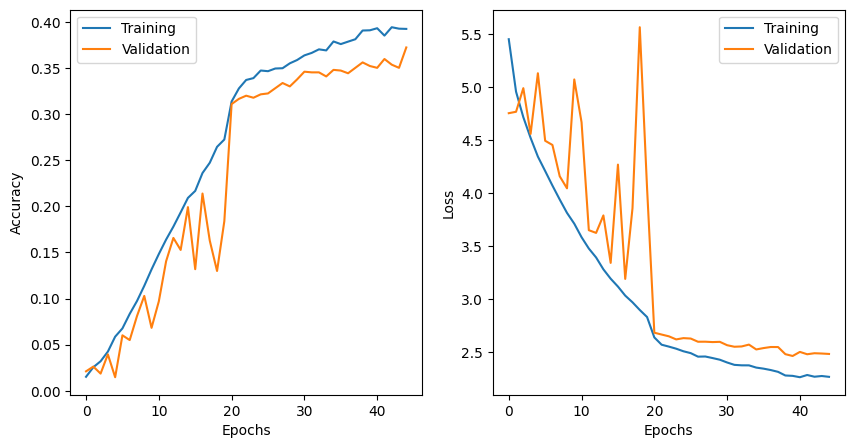

In [ ]:
#plot our loss and accuracy metrics
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()